In [1]:
%pip install git+https://github.com/openai/CLIP.git
%pip install numpy pandas scikit-learn
#%pip install torch torchvision clip-by-openai numpy pandas scikit-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i7jylj63
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i7jylj63
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import clip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from nltk.util import trigrams
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load datasets
fpath = "/content/drive/MyDrive/Task 2 NLP Dataset/"
train_path = fpath + "train/train.csv"
val_path = fpath + "val/val.csv"
test_path = fpath + "test/test.csv"
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [5]:
# Display dataset head and test set
print("Training Set")
print(train_df.head())
print("Testing Set")
print(test_df.head())

Training Set
     compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  
0  The image depicts two cartoon-style characters...      1  
1  The image depicts an oven with a large potato ...      0  
2  The image depicts an old, rolled-up parchment ...      0  
3  The image depicts a scene where a large tree h...      1  
4  The image depicts a whimsical scene featuring ..

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

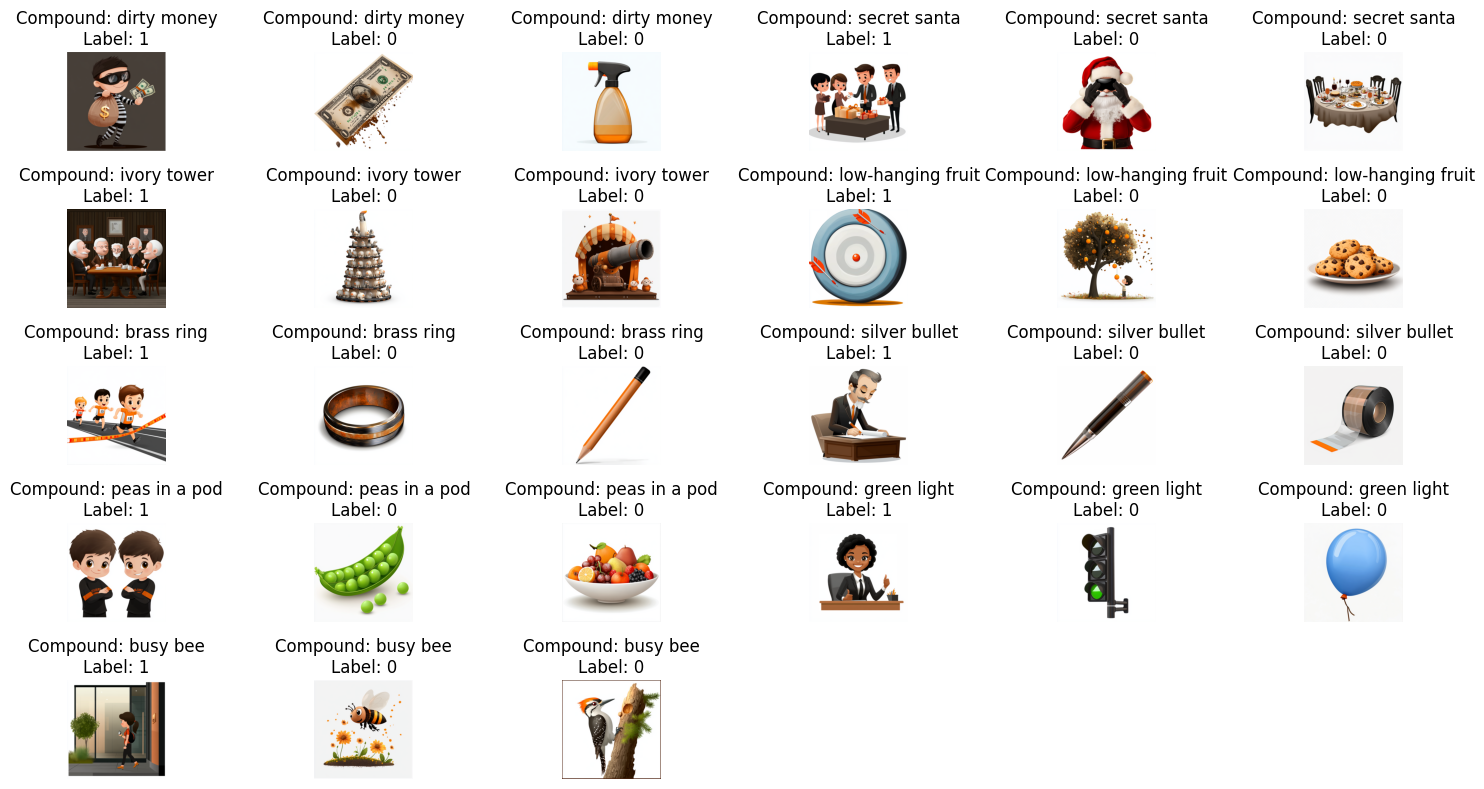

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


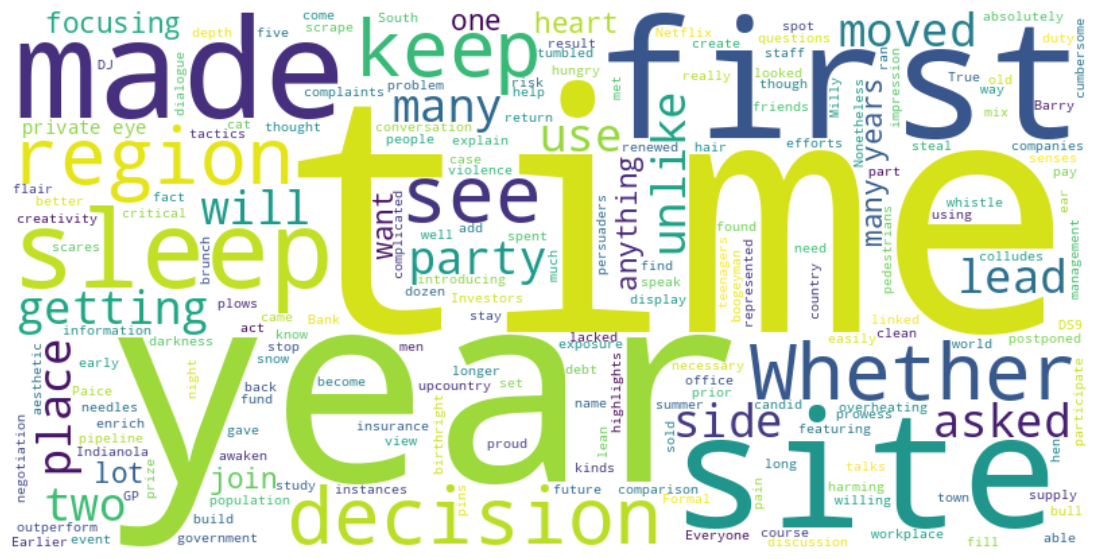

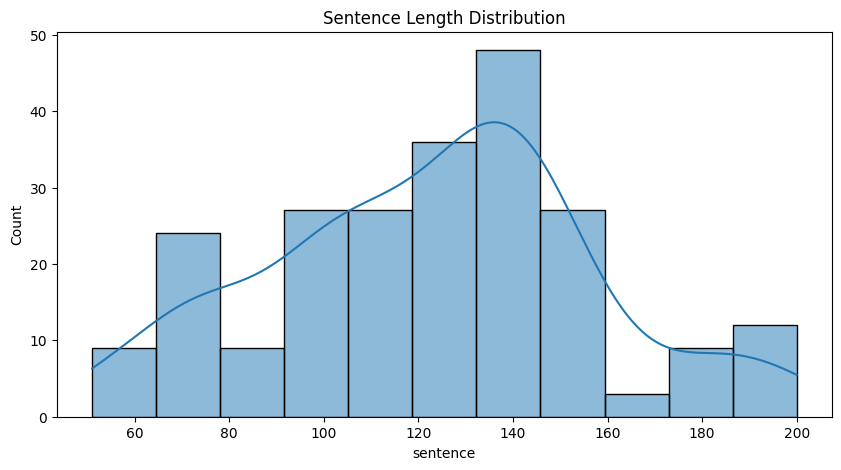

In [7]:

def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(15, 8))
    axes = axes.flatten()

    for idx, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"Compound: {row['compound']}\nLabel: {row['label']}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Hide any empty subplots (those beyond the dataset size)
    for idx in range(len(df), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualise_data(test_df, fpath+"test/images")


# Download missing tokenizer
nltk.download('punkt')

# Tokenizing the text
tokens = " ".join(train_df['sentence']).lower().split()

# Generate trigrams
trigram_freq = Counter(list(trigrams(tokens)))

# Convert trigrams to string format
trigram_dict = {" ".join(k): v for k, v in trigram_freq.items()}

# Generate Trigram WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict)

# Advanced EDA visualizations
text_corpus = " ".join(train_df['sentence'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(train_df['sentence'].apply(len), kde=True)
plt.title('Sentence Length Distribution')
plt.show()


## Step 1: NLP Exploratory Data Analysis (Note: only need to process the text data). Write down your code below.

In [8]:
nlp = spacy.load("en_core_web_sm")

for sent in train_df['sentence'].sample(3):
    doc = nlp(sent)
    print(f"Sentence: {sent}")
    print([(token.text, token.pos_, token.dep_) for token in doc])

Sentence: There is a display here featuring some of the unknown artifacts found at the site where a flying saucer allegedly crashed in 1947.
[('There', 'PRON', 'expl'), ('is', 'VERB', 'ROOT'), ('a', 'DET', 'det'), ('display', 'NOUN', 'attr'), ('here', 'ADV', 'advmod'), ('featuring', 'VERB', 'acl'), ('some', 'PRON', 'dobj'), ('of', 'ADP', 'prep'), ('the', 'DET', 'det'), ('unknown', 'ADJ', 'amod'), ('artifacts', 'NOUN', 'pobj'), ('found', 'VERB', 'acl'), ('at', 'ADP', 'prep'), ('the', 'DET', 'det'), ('site', 'NOUN', 'pobj'), ('where', 'SCONJ', 'advmod'), ('a', 'DET', 'det'), ('flying', 'VERB', 'amod'), ('saucer', 'NOUN', 'nsubj'), ('allegedly', 'ADV', 'advmod'), ('crashed', 'VERB', 'relcl'), ('in', 'ADP', 'prep'), ('1947', 'NUM', 'pobj'), ('.', 'PUNCT', 'punct')]
Sentence: The biggest red flag of all, though, was that neither newspaper ever linked to the supposed study of violence in teenagers.
[('The', 'DET', 'det'), ('biggest', 'ADJ', 'amod'), ('red', 'ADJ', 'amod'), ('flag', 'NOUN', '

##Step 2: LLM based Data Augmentation. Write down your code here.

In [9]:
paraphraser = pipeline('text-generation', model='gpt2-large')
augmented_rows = []

for idx, row in train_df.sample(10).iterrows():
    prompt = f"Paraphrase the following sentence: {row['sentence']}"  # corrected key
    results = paraphraser(prompt, max_length=80, num_return_sequences=2)
    for res in results:
        new_row = row.copy()
        new_row['sentence'] = res['generated_text']  # update this column as well
        augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)
train_df_augmented.to_csv(fpath + "train/augmented_train.csv", index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to 

##Step 3: Zero-shot prediction. Write down your code here

In [10]:
clip_model, clip_preprocess = clip.load("ViT-B/32")


optimal_threshold = 0
highest_f1 = 0
optimal_predictions = []

# Iterate over threshold values from 0.1 to 0.9 (step: 0.05) to find the best threshold
for threshold in np.arange(0.1, 0.91, 0.05):
    predicted_labels = []
    for _, row in val_df.iterrows():
        sentence, caption = row['sentence'], row['image_caption']

        text_inputs = clip.tokenize([sentence, caption], truncate=True).cuda()
        with torch.no_grad():
            text_embeddings = clip_model.encode_text(text_inputs)

        similarity_score = cosine_similarity(text_embeddings[0:1].cpu(), text_embeddings[1:2].cpu())[0][0]
        predicted_labels.append(1 if similarity_score > threshold else 0)

    f1 = f1_score(val_df['label'], predicted_labels, average='weighted', zero_division=0)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

    if f1 > highest_f1:
        highest_f1 = f1
        optimal_threshold = threshold
        optimal_predictions = predicted_labels.copy()

print(f"\nBest threshold: {optimal_threshold:.2f} with F1 Score: {highest_f1:.4f}")
print("Zero-shot classification accuracy:", accuracy_score(val_df['label'], optimal_predictions))
print("Detailed Classification Report:")
print(classification_report(val_df['label'], optimal_predictions, zero_division=0))

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 72.0MiB/s]


Threshold: 0.10, F1 Score: 0.1524
Threshold: 0.15, F1 Score: 0.2049
Threshold: 0.20, F1 Score: 0.2963
Threshold: 0.25, F1 Score: 0.4222
Threshold: 0.30, F1 Score: 0.4922
Threshold: 0.35, F1 Score: 0.4889
Threshold: 0.40, F1 Score: 0.5143
Threshold: 0.45, F1 Score: 0.4553
Threshold: 0.50, F1 Score: 0.4762
Threshold: 0.55, F1 Score: 0.5152
Threshold: 0.60, F1 Score: 0.5152
Threshold: 0.65, F1 Score: 0.5152
Threshold: 0.70, F1 Score: 0.5152
Threshold: 0.75, F1 Score: 0.5333
Threshold: 0.80, F1 Score: 0.5333
Threshold: 0.85, F1 Score: 0.5333
Threshold: 0.90, F1 Score: 0.5333

Best threshold: 0.75 with F1 Score: 0.5333
Zero-shot classification accuracy: 0.6666666666666666
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        18
           1       0.00      0.00      0.00         9

    accuracy                           0.67        27
   macro avg       0.33      0.50      0.40        27
weighted avg       0

The exploration of zero-shot prediction using CLIP with threshold optimization revealed that the binary classification performance is limited, with an F1 score of 0.53 and accuracy of 66%.

This indicates that CLIP's similarity approach, when applied to asingle-caption setup, does not effectively capture idiomatic relationships.

We suggest that for more reliable results, fine-tuning methods or multi-candidate setups should be considered.

##Step 4: Fine-tuning based and other prediction approaches. Write down your code here.

In [11]:
class IdiomDataset(Dataset):
    def __init__(self, dataframe, embedder):
        self.dataframe = dataframe
        self.embedder = embedder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        data_row = self.dataframe.iloc[index]
        sentence_embedding = self.embedder.encode(data_row['sentence'])  # corrected column name
        caption_embedding = self.embedder.encode(data_row['image_caption'])  # single caption
        combined_features = np.concatenate([sentence_embedding, caption_embedding])  # merge both embeddings
        return torch.tensor(combined_features, dtype=torch.float32), data_row['label']  # no subtraction

# Initialize the embedder using SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Create datasets for training and validation
train_dataset = IdiomDataset(train_df_augmented, embedder)
val_dataset = IdiomDataset(val_df, embedder)

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
import os

# Set up environment for debugging after an environment reset
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Enable detailed CUDA debugging messages

# Check GPU status and print info
import torch
print("CUDA Available:", torch.cuda.is_available())
!nvidia-smi

# Clear GPU cache
torch.cuda.empty_cache()

# Define the neural network classifier for binary classification
import torch.nn as nn
import torch.optim as optim

class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 512)  # First fully connected layer
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting
        self.fc2 = nn.Linear(512, 2)    # Output layer for binary classification
        self.relu = nn.ReLU()           # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after first layer
        x = self.dropout(x)         # Apply dropout to prevent overfitting
        return self.fc2(x)          # Output layer

# Initialize the model and move to GPU
model = BinaryClassifier().cuda()

# Set up loss function, optimizer, and learning rate scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Initialize variables for tracking best validation loss and early stopping
best_val_loss = float('inf')
patience_counter = 0
patience = 4
train_losses, val_losses = [], []

# Training loop for multiple epochs
for epoch in range(30):
    model.train()
    train_loss_sum = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()

        # Debugging: Log the batch shapes and labels
        print(f"[Epoch {epoch+1}] Batch input shape: {batch_x.shape}")
        print(f"[Epoch {epoch+1}] Batch_y dtype: {batch_y.dtype}, values: {batch_y}")

        # Check for invalid labels or NaN values
        if not (batch_y <= 1).all():
            raise ValueError(f"Invalid label found in batch: {batch_y}")
        if torch.isnan(batch_x).any():
            raise ValueError("NaN detected in batch features!")

        optimizer.zero_grad()
        output = model(batch_x)  # Forward pass
        print(f"[Epoch {epoch+1}] Output logits shape: {output.shape}")

        loss = loss_fn(output, batch_y)  # Compute loss
        loss.backward()                  # Backpropagate gradients
        optimizer.step()                 # Update weights
        train_loss_sum += loss.item()    # Accumulate training loss

    # Validation loop
    model.eval()
    val_loss_sum = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
            output = model(batch_x)  # Forward pass
            loss = loss_fn(output, batch_y)  # Compute loss
            val_loss_sum += loss.item()  # Accumulate validation loss
            val_preds += output.argmax(1).cpu().tolist()  # Get predicted labels
            val_targets += batch_y.cpu().tolist()  # Get true labels

    # Calculate average losses for train and validation sets
    avg_train_loss = train_loss_sum / len(train_loader)
    avg_val_loss = val_loss_sum / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

    # Print loss values for the current epoch
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Check for early stopping based on validation loss improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model if it has the best validation loss
        torch.save(model.state_dict(), fpath + "best_model_checkpoint.pt")
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break  # Stop training if patience is exhausted



CUDA Available: True
Fri Apr  4 12:16:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   52C    P0             29W /   72W |    3915MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

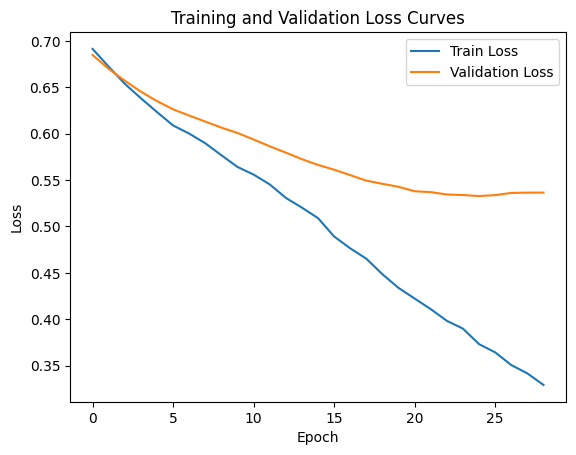

In [13]:
# Plot training/validation loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curves")
plt.show()

In [14]:
# Load best model checkpoint
model.load_state_dict(torch.load(fpath + "best_model_checkpoint.pt"))

<All keys matched successfully>

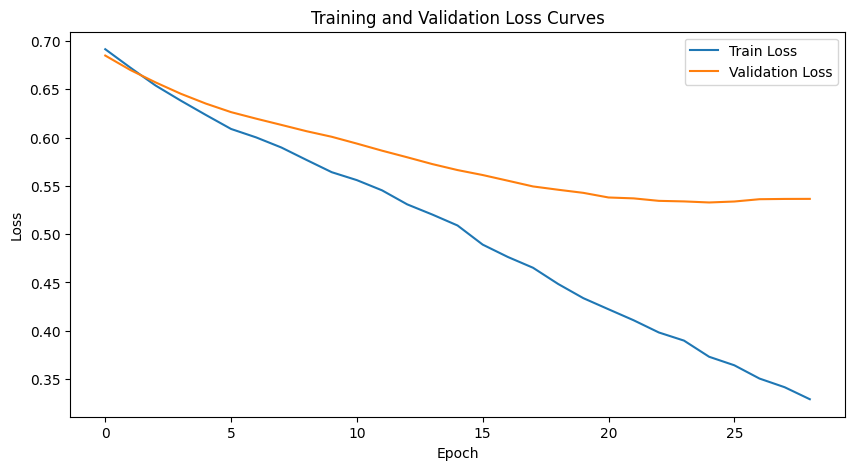

Test Accuracy: 0.8519
Test Precision: 0.8571
Test Recall: 0.6667
Test F1-score: 0.7500


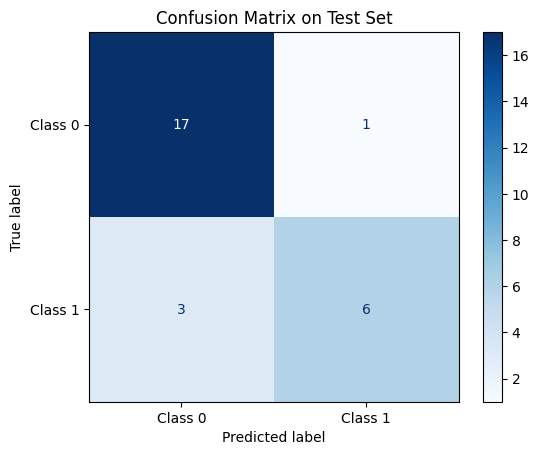

In [15]:
# Make sure IdiomDataset and embedder are defined as before
test_dataset = IdiomDataset(test_df, embedder)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 2)  # Binary classification output
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Load and evaluate best model
best_model = Classifier().cuda()
best_model.load_state_dict(torch.load(fpath + "best_model_checkpoint.pt"))
best_model.eval()

# Evaluate on test data
test_preds, test_targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
        outputs = best_model(batch_x)
        test_preds.extend(outputs.argmax(1).cpu().tolist())
        test_targets.extend(batch_y.cpu().tolist())

# Classification metrics
acc = accuracy_score(test_targets, test_preds)
prec = precision_score(test_targets, test_preds)
rec = recall_score(test_targets, test_preds)
f1 = f1_score(test_targets, test_preds)
cm = confusion_matrix(test_targets, test_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [16]:
import pandas as pd

results_df = pd.DataFrame({
    "Index": range(len(test_targets)),
    "Actual Label": test_targets,
    "Predicted Label": test_preds
})

# Display first 30 for reference
display(results_df.head(30))

# If you want to save results:
results_df.to_csv(fpath + "test_predictions_vs_actual.csv", index=False)

Index  Actual Label  Predicted Label
0       0             1                1
1       1             0                1
2       2             0                0
3       3             1                1
4       4             0                0
5       5             0                0
6       6             1                0
7       7             0                0
8       8             0                0
9       9             1                0
10     10             0                0
11     11             0                0
12     12             1                0
13     13             0                0
14     14             0                0
15     15             1                1
16     16             0                0
17     17             0                0
18     18             1                1
19     19             0                0
20     20             0                0
21     21             1                1
22     22             0                0
23     23             0                0
24     24             1                1
25     25             0                0
26     26             0                0

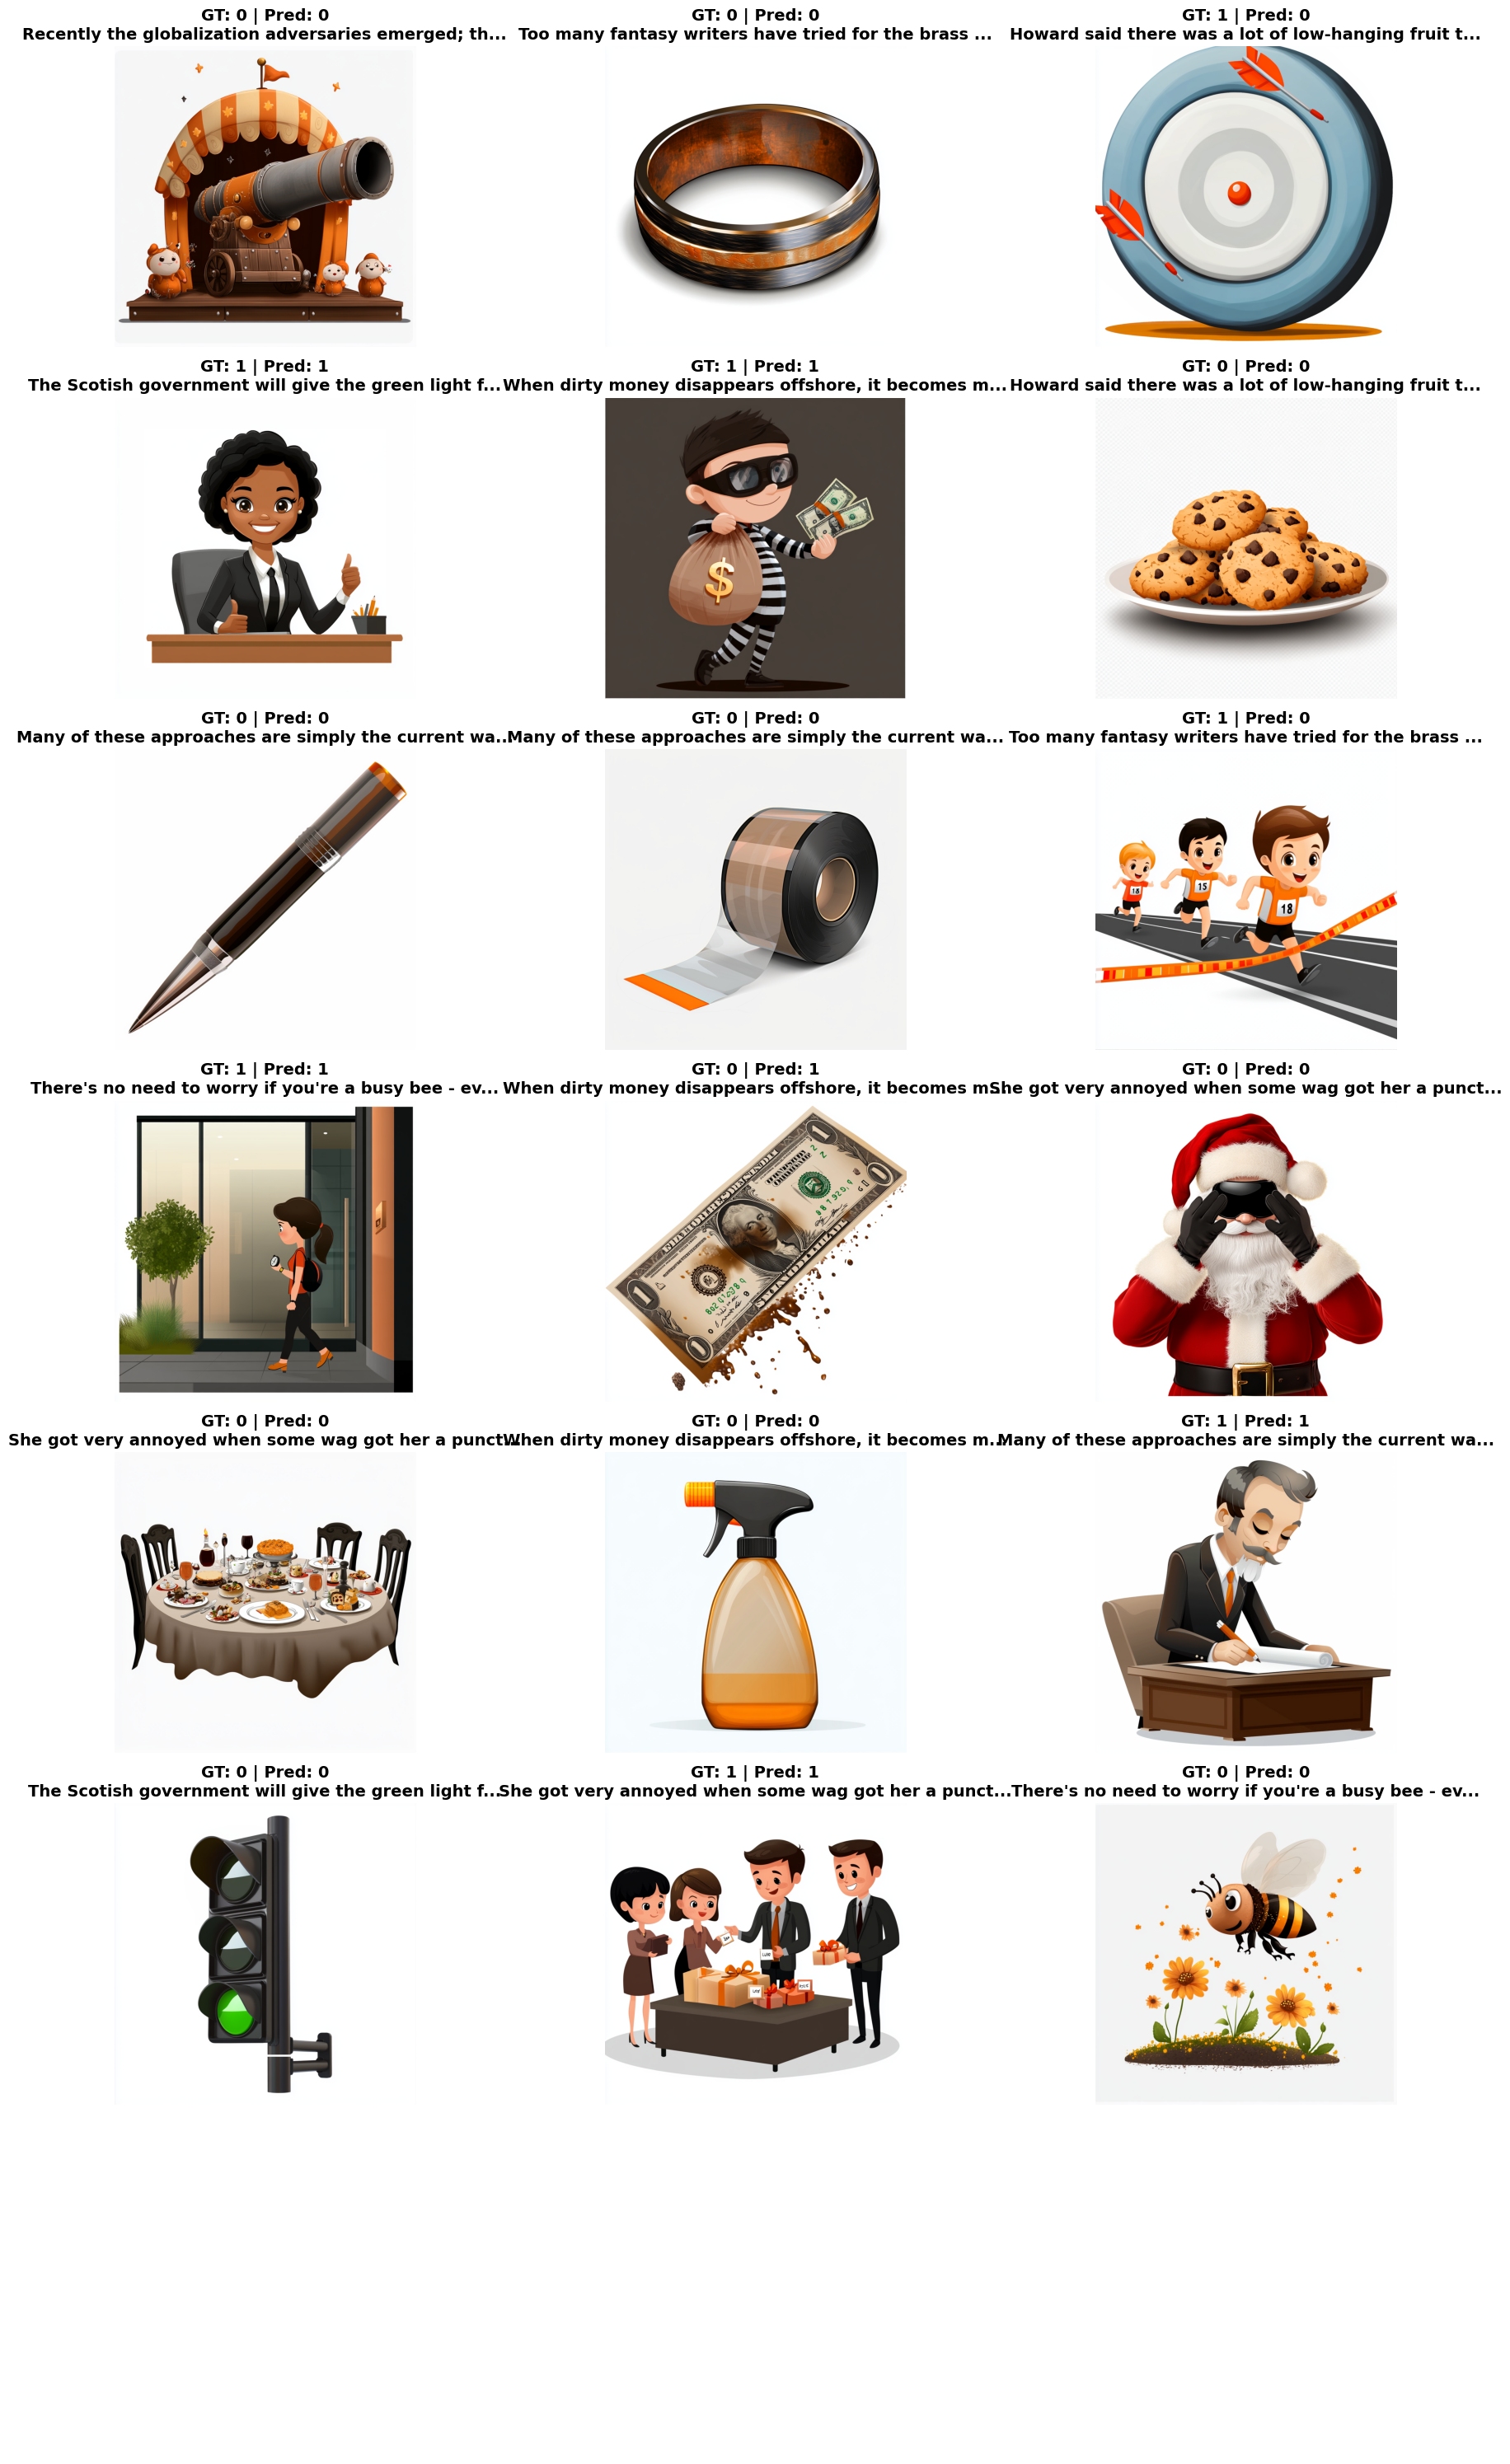

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from PIL import Image

# Assuming test_loader exists and contains features and labels, and test_df has 'image_name' and 'sentence'
test_image_names = test_df['image_name'].tolist()
test_sentences = test_df['sentence'].tolist()
test_targets, test_preds = [], []

best_model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.long().cuda()
        outputs = best_model(batch_x)
        preds = outputs.argmax(1).cpu().tolist()
        test_targets.extend(batch_y.cpu().tolist())
        test_preds.extend(preds)

# Build combined dataframe
test_df_with_preds = pd.DataFrame({
    'image_name': test_image_names,
    'sentence': test_sentences,
    'ground_truth': test_targets,
    'predicted': test_preds
})

# Function to visualize original vs predicted
def visualize_test_predictions(df, image_folder, n_samples=18):
    samples = df.sample(n=min(len(df), n_samples), random_state=42).reset_index(drop=True)
    fig, axes = plt.subplots(nrows=(n_samples // 3) + 1, ncols=3, figsize=(18, (n_samples // 3) * 5))
    axes = axes.flatten()

    for idx, row in samples.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            sentence = row['sentence'][:50] + '...' if len(row['sentence']) > 50 else row['sentence']
            ax.set_title(f"GT: {row['ground_truth']} | Pred: {row['predicted']}\n{sentence}", fontsize=14, weight='bold')
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_test_predictions(test_df_with_preds, fpath + "test/images")